# Text Classification For Serbian Science Journals
<p>
The goal of this project is to see how different text classification algorithms classify text paragraphs of articles from Serbian scientific journals.


The data used for this project was made using an online archive of published Serbian scientific journals called 'Srpski Citatni Indeks', link of the site:
https://scindeks.ceon.rs/  
Data contains 1700 paragraphs that are split into 9 categories. These are the following categories: 
   - Architecture and construction engineering
   - Biology
   - Economy
   - Geoscience
   - Chemistry
   - Informatics and electrical engineering
   - Mathematics
   - Medicine
   - Agriculture

   
Each paragraph is also labeled whether it is written in Serbian or English. Due to the nature of Serbian scientific community, there are more scientific works in English language as they are more available to the international community. Some categories have only scientific works that are written in English, as there are minimal to none written in Serbian. Here is the ratio of Serbian to English paragraphs 
for each category:
   - Architecture and construction engineering - Serbian ~48%, English ~52%
   - Biology - Serbian ~39%, English 71%
   - Economy - Serbian ~45%, English ~55%
   - Geoscience - Serbian ~30%, English ~%70
   - Chemistry - Serbian 0%, English 100%
   - Informatics and electrical engineering - Serbian ~3%, English ~97%
   - Mathematics - Serbian 0%, Englsih 100%
   - Medicine - Serbian ~52%, English ~48%
   - Agriculture - Serbian ~51%, English 49%


Algorithms that are used in this project are: Multionomial Naive Bayes, K-Nearest Neighbours and Support Vector Machine. Besides them there are two vectorizers on which the algorithms are tested on: CountVectorizer and TfidfVectorizer

Libraries that are included in this project are: Skicit-Learn, Pandas, Numpy, MatplotLib, NLTK and a Serbian library for NLP, SrbAi

Metrics for evaluation are Skicit-Learns Accuracy and Macro Average metrics.

The data is split 70% into test data, 15% into validation data, 15% into test data
</p>




In [1]:
import re
import pandas as pd
import numpy as np
from srbai.SintaktickiOperatori import spellcheck
from srbai.SintaktickiOperatori.stemmer_nm import stem_str, stem_arr
from srbai.JezickiModeli import FastText
from sklearn.naive_bayes import MultinomialNB
import csv
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<p>We load the csv file content, define its delimiter, and rewrite it into a new csv file, with lineterminators accurately representing end of each row</p>

In [2]:
custom_dialect = csv.excel()
custom_dialect.delimiter = '»'

file_path = 'data/serbian_science_journals_dataset.csv'

with open(file_path, 'r', encoding="utf-8") as file:
    file_content = file.read()

In [3]:

file_content = file_content.replace('\n', '').replace('\r', '').replace('\t', '')
file_content = file_content.replace('«', '\n')

with open('data/serbian_science_journals_dataset_modified.csv', 'w', encoding="utf-8") as file:
    file.write(file_content)

file_path = 'data/serbian_science_journals_dataset_modified.csv'

In [4]:
with open(file_path, 'r', newline='', encoding="utf-8") as csv_file:
    reader = csv.reader(csv_file, dialect=custom_dialect)
    data = list(reader)

df = pd.DataFrame(data)

# Preprocessing

<p>We filter through insufficient characters in our data</p>

In [5]:
pattern = r"[/&|!,:;()\@.#\'\"\[\]{}+\^*/=\$_–—%€°™©><`~0-9-]"

df = df.replace(pattern, ' ', regex=True)
df = df.replace(r"[?]", 'cy', regex=True)
df = df.replace(r"[\r\n\t]", ' ', regex=True)

<p>We define our collections per column, one for languages, one for categories, and one where our paragraphs are stored</p>

In [6]:
column_length = len(df[1])
df_language_collection = [[] for _ in range(column_length)]
df_label_collection = [[] for _ in range(column_length)]
df_token_collection = [[] for _ in range(column_length)]

for idx, language in enumerate(df[2]):
    df_language_collection[idx] = language

for idx, label in enumerate(df[0]):
    df_label_collection[idx] = label

for idx, text_paragraph in enumerate(df[1]):
    text_paragraph = text_paragraph.lower()
    df_token_collection[idx] = nltk.WhitespaceTokenizer().tokenize(text_paragraph)


<p>The commented code represents an attempt to manually categorize each paragraph whether it was written in Serbian or English using SrbAi's SpellCheck, however the process was inefficient and too slow for it to be practical</p>

In [7]:
#-----------THIS FEATURE IS NOT FUNCTIONAL DUE TO SRBAI TOOLS INEFFICIENCY-------------
#serbian_indexes = []
#english_indexes = []
#sc = spellcheck.SpellCheck('sr-latin')

#for idx, text_paragraph_tokens in enumerate(df_token_collection):
    
#    total_token_number = len(df_token_collection[idx])
#    mispelled_token_number = 0
#    mispell_rate = 0

#    for idx_token, token in enumerate(text_paragraph_tokens):
       

#        correction = sc.spellcheck(token)
#        if correction:
#            serbian_indexes.append(idx_token)

#            if(idx < 10):
#                print(token)
#                print(correction)
#                print("serbian")
#        else:
#            mispelled_token_number = mispelled_token_number + 1
#            english_indexes.append(idx_token)
#
#            if(idx < 10):
#                print("english")
#    



<p>We iterate through the collection of tokens, each according to their language label, if the token is in Serbian we use SrbAi's Stemming and stop words from their package as well as some custom additional words of ours. If the token is in English we use NLTK's WordNetLemmatizer and also add some custom additional stop words according to our projects needs</p>

In [8]:
#CONTENT OF 'serbian_stopwords.txt' FILE IS COPIED FROM SRBAI serbian_stopwords.txt FILE
file_path = 'stop_words/serbian_stopwords.txt'

with open(file_path, 'r', newline='', encoding='utf-8') as file:
    data = file.read()

serbian_stop_words = data.split(',')
english_stop_words = stopwords.words()

if(serbian_stop_words.__contains__('jesam') or serbian_stop_words.__contains__('ali') or serbian_stop_words.__contains__('ili') or
   serbian_stop_words.__contains__('slika') or serbian_stop_words.__contains__('tabela') or serbian_stop_words.__contains__('tab')):
    serbian_stop_words.append('jesam','ali','ili','slika','tabela','tab')


if(english_stop_words.__contains__('table') or english_stop_words.__contains__('image') or english_stop_words.__contains__('figure') or
   english_stop_words.__contains__('fig')):
    english_stop_words.append('table', 'image', 'figure', 'fig')



In [9]:
lemmatizer = nltk.stem.WordNetLemmatizer()

for idx, text_paragraph in enumerate(df[1]):

    if df_language_collection[idx] == 'Serbian':
        df_token_collection[idx] = stem_arr(text_paragraph)
        df_token_collection[idx] = [token for token in df_token_collection[idx] if len(token) > 2]

        df_token_collection[idx] = [token for token in df_token_collection[idx] if token not in serbian_stop_words]
        df_token_collection[idx] = [token for token in df_token_collection[idx] if token not in english_stop_words]
        #df_token_collection[idx] = text_preprocessing.remove_stopwords(df_token_collection[idx])
        #print("Serbian")
        #print(df_token_collection[idx])
    else:
        df_token_collection[idx] = nltk.WhitespaceTokenizer().tokenize(text_paragraph)
        df_token_collection[idx] = [token for token in df_token_collection[idx] if len(token) > 2]
        for idx_token, _ in enumerate(df_token_collection[idx]):
            df_token_collection[idx][idx_token] = lemmatizer.lemmatize(df_token_collection[idx][idx_token])
            df_token_collection[idx][idx_token] = df_token_collection[idx][idx_token].lower()

        df_token_collection[idx] = [token for token in df_token_collection[idx] if token not in english_stop_words]

        #print("English")
        #print(df_token_collection[idx])


# Vectorizers

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


In [11]:
countVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()
classifier = MultinomialNB()
label_encoder = LabelEncoder()

<p>We conjoin our tokens into a document string</p>

In [12]:
df_x = [[] for _ in range(column_length)]
for idx, _ in enumerate(df_x):
    df_x[idx] = " ".join(df_token_collection[idx])

df_x_documents = [' '.join(tokens) for tokens in df_token_collection]

<p>Our random seed</p>

In [13]:
random_state_seed = 42

<p>We fit and transform our data to the vectors, and encode our categories in y</p>

In [14]:
X = [[] for _ in range(column_length)]
y = [[] for _ in range(column_length)]

X = countVectorizer.fit_transform(df_x_documents)
y = label_encoder.fit_transform(df_label_collection)

X_tf = tfidfVectorizer.fit_transform(df_x_documents)

# Validation Data

<p>We split our data into train and validation data, according to the random seed</p>

In [15]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.15, random_state=random_state_seed)

X_train_tf, x_validate_tf, y_train_tf, y_validate_tf = train_test_split(X_tf, y, test_size=0.15, random_state=random_state_seed)

<p>We fit and predict our data according to our classifier, then we represent how accurate the predictions are with Accuracy and Macro Average metric scores, and with confusion matrix visually as well. We test our algorithm on both CountVectorizer, as well as TfidfVectorizer</p>

<p>Multinomial Naive Bayes with Count Vectorizer </p>

Accuracy score: 
0.8431372549019608
Macro Average score: 
0.8449830332471222


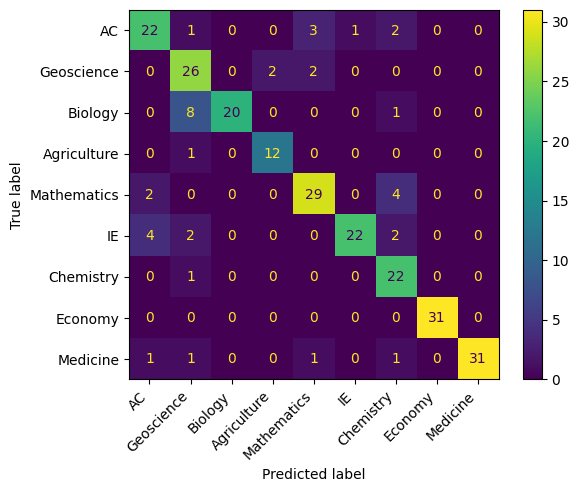

In [16]:
multinomialnb_classifier = MultinomialNB()

multinomialnb_classifier.fit(X_train, y_train)

y_pred = multinomialnb_classifier.predict(X_validate)



accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = [ 'AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Multinomial Naive Bayes with TF-IDF Vectorizer </p>

Accuracy score: 
0.807843137254902
Macro Average score: 
0.8041011856720091


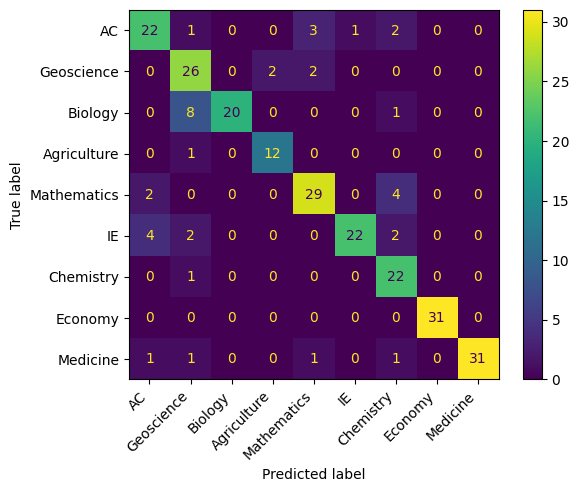

In [17]:
multinomialnb_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = multinomialnb_classifier.predict(x_validate_tf)



accuracy = accuracy_score(y_validate_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = [ 'AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

In [18]:
from sklearn.neighbors import KNeighborsClassifier


<p>K-Nearest Neighbors with Count Vectorizer </p>

Accuracy score: 
0.24705882352941178
Macro Average score: 
0.22908773976849092


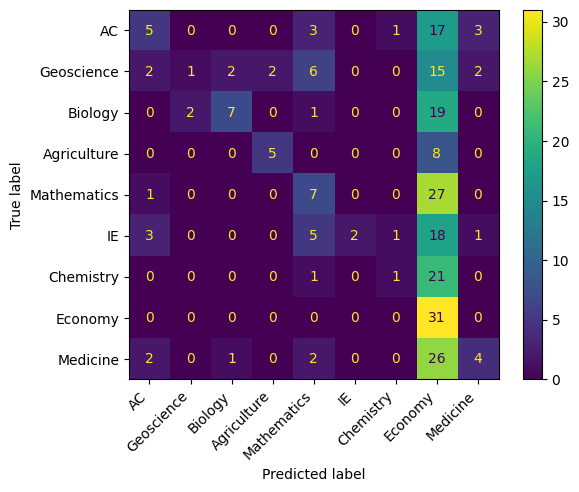

In [19]:
knn_classifier = KNeighborsClassifier(n_neighbors=9)
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_validate)



accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>K-Nearest Neighbors with TF-IDF Vectorizer </p>

Accuracy score: 
0.8
Macro Average score: 
0.7964658798408162


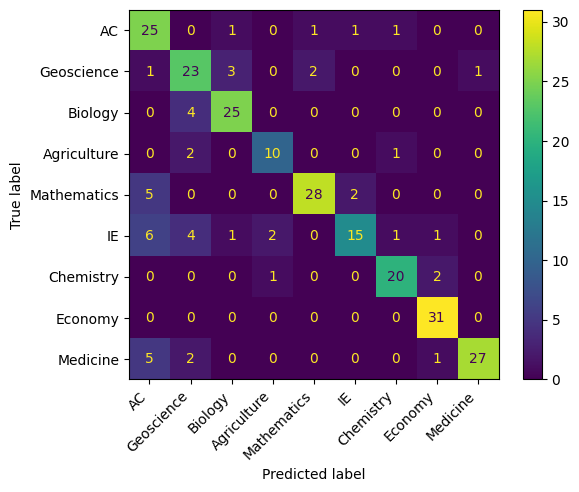

In [20]:
knn_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = knn_classifier.predict(x_validate_tf)



accuracy = accuracy_score(y_validate_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate_tf,y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()



In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

<p>Support Vector Machine with Counter Vectorizer </p>

Accuracy score: 
0.7372549019607844
Macro Average score: 
0.7393024026491746


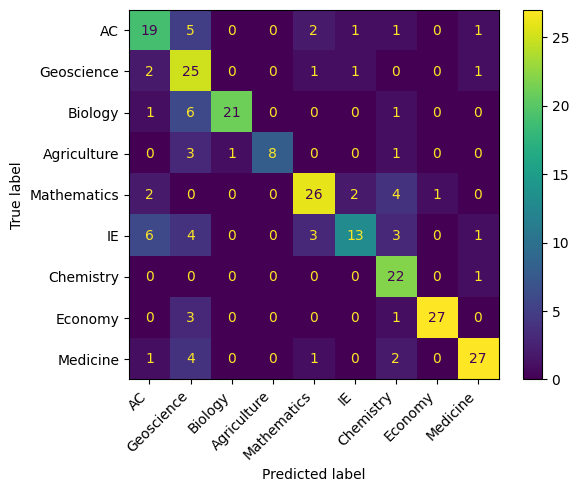

In [22]:
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)

y_pred = svc_classifier.predict(X_validate)



accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Support Vector Machine with TF-IDF Vectorizer </p>

Accuracy score: 
0.8392156862745098
Macro Average score: 
0.8314847865207708


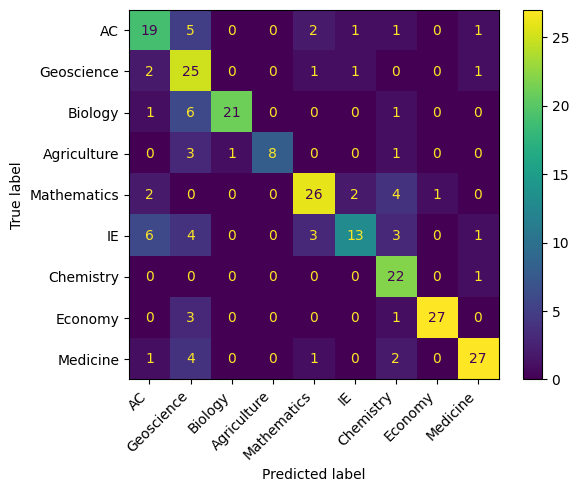

In [23]:
svc_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = svc_classifier.predict(x_validate_tf)



accuracy = accuracy_score(y_validate_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

# Test Data

<p>Now we test our data on fine-tuned variations of our algorithms</p>

In [24]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV




<p>We split our data into train and test data, according to the random seed</p>

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state_seed)

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.15, random_state=random_state_seed)

<p>Multinomial Naive Bayes Count Vectorizer </p>

Accuracy score: 
0.8431372549019608
Macro Average score: 
0.8449830332471222


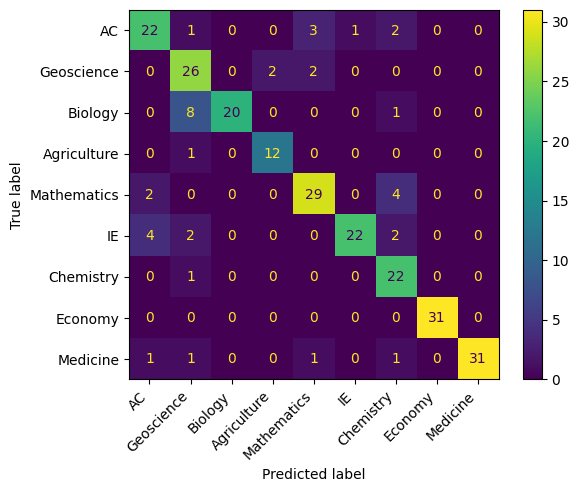

In [26]:

multinomialnb_classifier = MultinomialNB(alpha=1)
multinomialnb_classifier.fit(X_train, y_train)


y_pred = multinomialnb_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                              'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Multinomial Naive Bayes TF-IDF Vectorizer </p>

Accuracy score: 
0.807843137254902
Macro Average score: 
0.8041011856720091


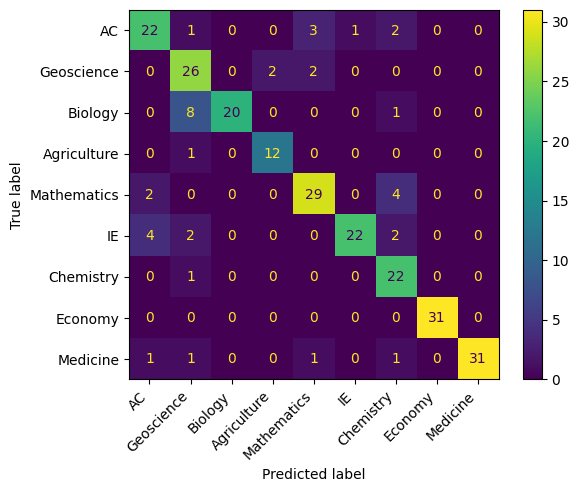

In [27]:
multinomialnb_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = multinomialnb_classifier.predict(x_validate_tf)



accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = [ 'AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test_tf,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Imporved K-Nearest Neighbor with Count Vectorizer </p>

Accuracy score: 
0.396078431372549
Macro Average score: 
0.39443126448776167


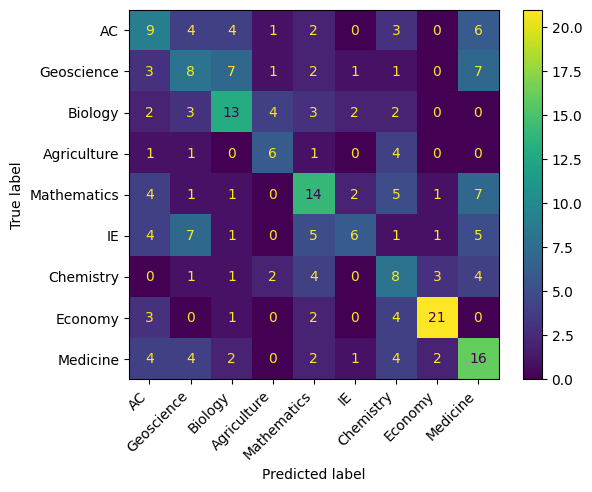

In [28]:
from sklearn.neighbors import KNeighborsTransformer

knn_transformer = KNeighborsTransformer(n_neighbors=9)
knn_classifier = KNeighborsClassifier(weights='distance')

knn_pipeline = make_pipeline(knn_transformer, knn_classifier)
knn_pipeline.fit(X_train, y_train)

y_pred = knn_pipeline.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Improved K-Nearest Neighbor with TF-IDF Vectorizer </p>

Accuracy score: 
0.792156862745098
Macro Average score: 
0.7975575502214848


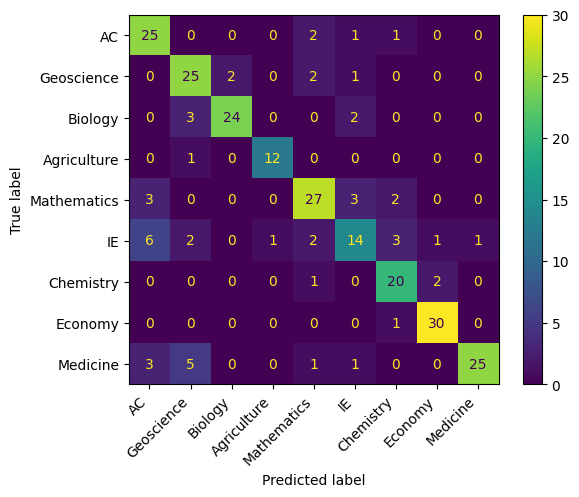

In [29]:
knn_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = knn_classifier.predict(x_validate_tf)


accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test_tf,y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Improved Support Vector Machine with Count Vectorizer </p>

Accuracy score: 
0.807843137254902
Macro Average score: 
0.8101442255712243


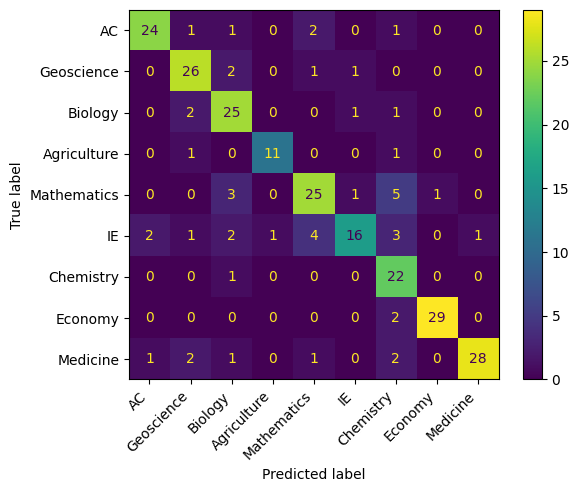

In [30]:

svc_classifier = SVC(kernel='sigmoid')


svc_classifier.fit(X_train, y_train)

y_pred = svc_classifier.predict(X_validate)



accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Improved Support Vector Machine with TF-IDF Vectorizer </p>

Accuracy score: 
0.8901960784313725
Macro Average score: 
0.8929060789493598


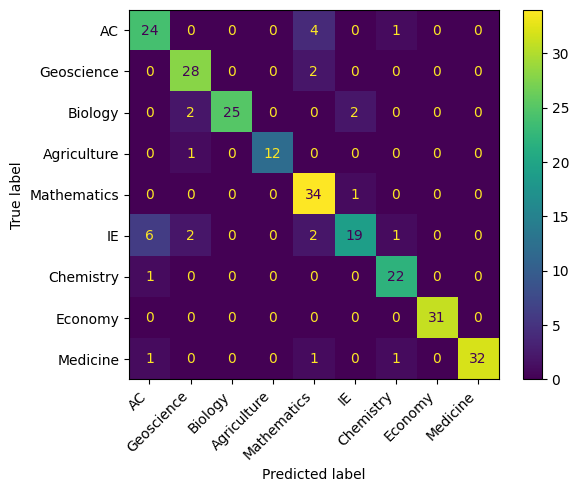

In [31]:
svc_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = svc_classifier.predict(x_validate_tf)



accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score: " )
print( accuracy)
macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print( macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test_tf,y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

In [32]:
#-------ATTEMPT TO IMPLEMENT WORD2VECTOR VECTORIZATION, ITS FUNCTIONAL BUT ITS SUCCESS RATE IS TOO LOW TO BE PROPERLY OBSERVED-------------

# from gensim.models import Word2Vec
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.decomposition import PCA

# X_train_w2v, X_validate_w2v, y_train_w2v, y_validate_w2v = train_test_split(df_x_documents, y, test_size=0.15, random_state=random_state_seed)

# X_train_w2v

# tokenized_docs = [doc.split() for doc in X_train_w2v]
# tokenized_docs_validate = [doc.split() for doc in X_validate_w2v]
# #tokenized_docs = tokenized_docs.extend(tokenized_docs_validate)
# tokenized_docs = tokenized_docs + tokenized_docs_validate




# # Train the Word2Vec model
# word2vec_model = Word2Vec(tokenized_docs, vector_size=500, window=5, min_count=1, workers=4)

# # Tokenize and convert the training set into feature vectors
# X_train_w2v = np.array([np.mean([word2vec_model.wv[word] for word in doc if word], axis=0) for doc in tokenized_docs])

# # Perform dimensionality reduction with PCA on X_train_w2v
# num_dimensions = 50  # Choose the number of dimensions you want
# pca = PCA(n_components=num_dimensions)
# X_train_w2v_reduced = pca.fit_transform(X_train_w2v)

# # Convert the reduced-dimensional feature vectors into a 2D numpy array
# X_train_w2v_array = np.array(X_train_w2v_reduced)

# scaler = MinMaxScaler(feature_range=(0,1))
# scaler.fit(X_train_w2v_array)
# X_train_w2v_array_normalized = scaler.transform(X_train_w2v_array)
# X_train_w2v_array_normalized = X_train_w2v_array_normalized[:len(y_train_w2v)]




# # Train your classifier (in this case, Naive Bayes)
# multinomialnb_classifier = MultinomialNB()
# multinomialnb_classifier.fit(X_train_w2v_array_normalized, y_train_w2v)

# # Tokenize and convert the validation set into feature vectors
# X_validate_w2v = np.array([np.mean([word2vec_model.wv[word] for word in doc], axis=0) for doc in tokenized_docs_validate])
# X_validate_w2v_reduced = pca.transform(X_validate_w2v)

# # Predict the labels for the validation set
# y_pred = multinomialnb_classifier.predict(X_validate_w2v_reduced)

# # Calculate and print the accuracy
# accuracy = accuracy_score(y_validate, y_pred)
# print("Accuracy:", accuracy)

# # Calculate and print the macro-average F1 score
# macro_average = f1_score(y_validate, y_pred, average='macro')
# print("Macro-average F1 score:", macro_average)

# # Generate and display the confusion matrix
# display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
# cm = confusion_matrix(y_validate, y_pred)
# cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels) 
# cm_display.plot()
# plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
# plt.show()





# # Train your classifier (in this case, Naive Bayes)
# knn_classifier = KNeighborsClassifier(weights='distance')
# knn_classifier.fit(X_train_w2v_array_normalized, y_train_w2v)

# # Tokenize and convert the validation set into feature vectors
# X_validate_w2v = np.array([np.mean([word2vec_model.wv[word] for word in doc], axis=0) for doc in tokenized_docs_validate])
# X_validate_w2v_reduced = pca.transform(X_validate_w2v)

# # Predict the labels for the validation set
# y_pred = knn_classifier.predict(X_validate_w2v_reduced)

# # Calculate and print the accuracy
# accuracy = accuracy_score(y_validate, y_pred)
# print("Accuracy:", accuracy)

# # Calculate and print the macro-average F1 score
# macro_average = f1_score(y_validate, y_pred, average='macro')
# print("Macro-average F1 score:", macro_average)

# # Generate and display the confusion matrix
# display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
# cm = confusion_matrix(y_validate, y_pred)
# cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels) 
# cm_display.plot()
# plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
# plt.show()



# # Train your classifier (in this case, Naive Bayes)
# svc_classifier = SVC(kernel='sigmoid')


# svc_classifier.fit(X_train_w2v_array_normalized, y_train_w2v)

# # Tokenize and convert the validation set into feature vectors
# X_validate_w2v = np.array([np.mean([word2vec_model.wv[word] for word in doc], axis=0) for doc in tokenized_docs_validate])
# X_validate_w2v_reduced = pca.transform(X_validate_w2v)

# # Predict the labels for the validation set
# y_pred = knn_classifier.predict(X_validate_w2v_reduced)

# # Calculate and print the accuracy
# accuracy = accuracy_score(y_validate, y_pred)
# print("Accuracy:", accuracy)

# # Calculate and print the macro-average F1 score
# macro_average = f1_score(y_validate, y_pred, average='macro')
# print("Macro-average F1 score:", macro_average)

# # Generate and display the confusion matrix
# display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
# cm = confusion_matrix(y_validate, y_pred)
# cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels) 
# cm_display.plot()
# plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
# plt.show()
